In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code is to show how to optimize the parameter of the time-dependent OU processes based on MLE. This code has been vectorized so that it becomes possible to optimize a set of different sample paths at the same time

Noisy Observations from the SDE:

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [2]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.04

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

Change dtype

In [3]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [4]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

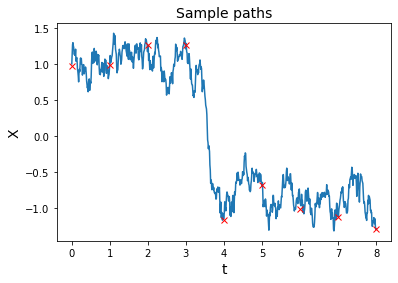

In [5]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [6]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [7]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

Variational inference: KL

In [8]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
                - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
                + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
                                                                                alpha * beta * B(s, beta-1))
        
        num = func(self.ou.pts, self.ou.trj)

        return -0.5 * torch.trapezoid(abs(num), x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (-1 * (u ** 4) + (4+r)*(u ** 2)/2 - u*r*(alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
            
        
        return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [9]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [10]:
import tqdm as tq

In [11]:
D = 30

alpha_ = torch.tensor([0.])
beta_ = torch.rand(1)
r_ = torch.rand(1)

m0 = obs[0].repeat(D, 1)


learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    alpha_D = alpha_.repeat(D, 1)
    beta_D = beta_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((beta_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0, r_D)
    f_of_X = -1 * (elbo.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
    beta_grad = torch.mean(f_of_X * scores['beta'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    beta_ -= learning_rate * beta_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  4%|█▊                                        | 13/300 [00:00<00:04, 60.59it/s]

beta =  tensor([0.5131]) alpha =  tensor([1.4003e-06]) r =  tensor([0.7360]) (Negative) ELBO =  tensor(79.5457, dtype=torch.float64)


 37%|███████████████▏                         | 111/300 [00:01<00:02, 67.57it/s]

beta =  tensor([0.5131]) alpha =  tensor([-0.0005]) r =  tensor([0.7372]) (Negative) ELBO =  tensor(129.0332, dtype=torch.float64)


 70%|████████████████████████████▌            | 209/300 [00:03<00:01, 64.86it/s]

beta =  tensor([0.5131]) alpha =  tensor([-0.0009]) r =  tensor([0.7385]) (Negative) ELBO =  tensor(94.8561, dtype=torch.float64)


100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 66.18it/s]


**Posterior mean**

In [12]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0[0]

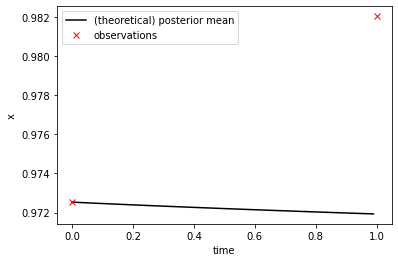

In [13]:
plt.plot(true_sde_pts[:100], compute_mean(true_sde_pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde_pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

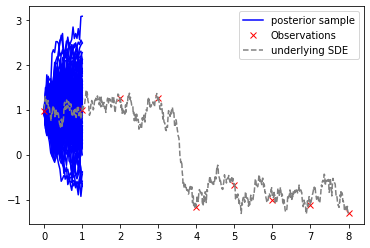

In [14]:
S = 100
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = m0[0].repeat(S, 1), m0 = m0[0].repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

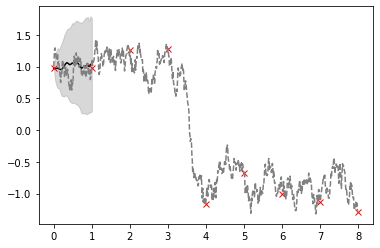

In [15]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

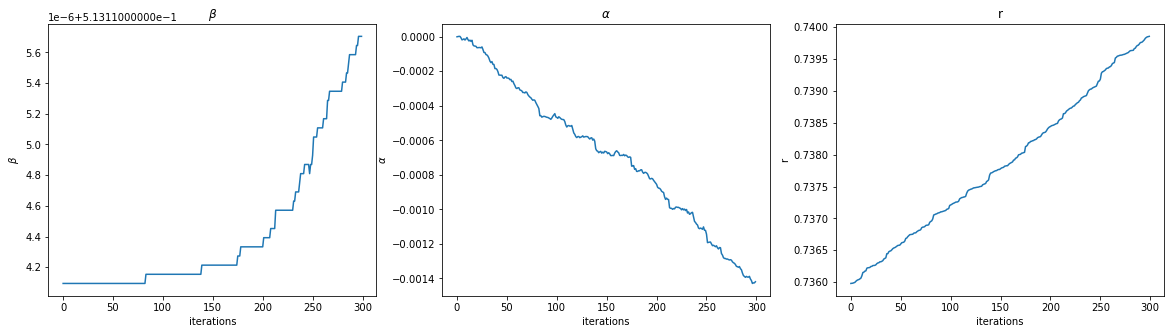

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

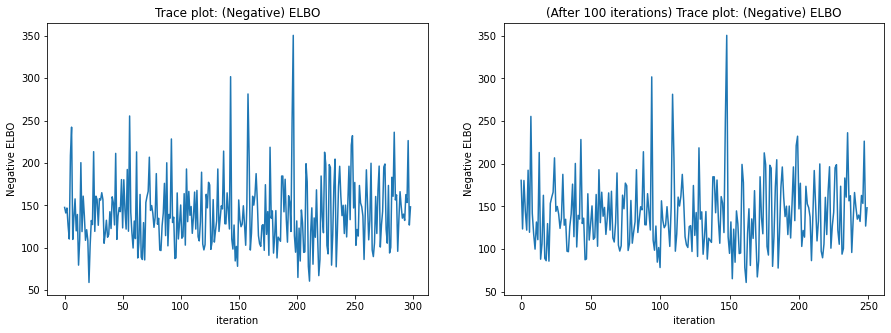

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

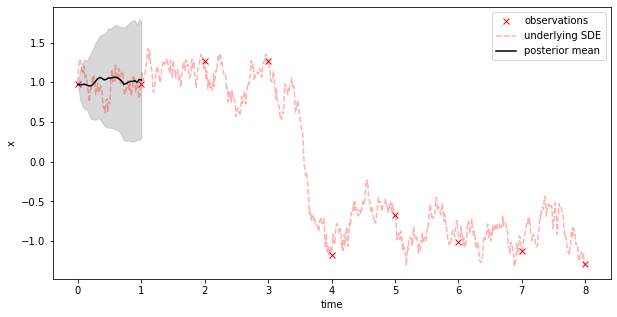

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde_pts,true_sde_trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [32]:
D = 80
S = 50
learning_rate = 0.0001
lr = learning_rate
IT = 400
z0 = obs[0]

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT))
KL_traces = np.empty((len(obs_time) -1 , IT))
NLL_traces = np.empty((len(obs_time) -1 , IT))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    beta_ = torch.rand(1)
    r_ = torch.rand(1)
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
#         print("after z0 = ", z0)
        old = alpha_ + beta_ + r_
        
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)

        # Compute (negative) ELBO
        vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo_ = ELBO(vi_)
        kl_ = elbo_.KL_ito() + elbo_.KL_rest()
        NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
        elbo_estimate = -1 * (kl_ + NLL_)
        
        
        elbo_traces[t, i] = torch.mean(elbo_estimate).clone()
        KL_traces[t, i] = torch.mean(kl_).clone()
        NLL_traces[t, i] = torch.mean(NLL_).clone()
        
        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, z0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)))

        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])

        # Update the parameter
        beta_ -= learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

            # It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()
        pars_traces[2, t, i] = r_.clone()

        new = alpha_.clone() + beta_.clone() + r_.clone()
#         conv = abs(old - new)
        i += 1
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy(), "r = ", r_.data.numpy(), "(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
#     print("z0 = ", z0)
    
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = z0.repeat(S, 1), alpha = alpha_, beta = beta_, sigma = sde_sigma, r = r_, D = S, dN = 30, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.08709136] beta =  [0.36384788] r =  [1.0066113] (Neg) elbo =  102.41279093917497
alpha =  [-0.1393208] beta =  [0.38026574] r =  [1.3523529] (Neg) elbo =  98.8746207843548
alpha =  [-0.16339953] beta =  [0.3898689] r =  [1.5868012] (Neg) elbo =  68.94487750958645
alpha =  [-0.16362478] beta =  [0.3887265] r =  [1.7968158] (Neg) elbo =  83.40216913760348
alpha =  [-0.16083284] beta =  [0.38608927] r =  [1.9776839] (Neg) elbo =  55.23923175592263
alpha =  [-0.1586231] beta =  [0.38418546] r =  [2.117071] (Neg) elbo =  38.90934221142786
alpha =  [-0.1240123] beta =  [0.3688607] r =  [2.229123] (Neg) elbo =  61.40192727003208


 12%|█████▋                                       | 1/8 [00:17<02:03, 17.63s/it]

alpha =  [-0.13018784] beta =  [0.37069604] r =  [2.343715] (Neg) elbo =  47.45211685878825
alpha =  [0.23204835] beta =  [0.7060307] r =  [1.2482473] (Neg) elbo =  105.82136516952482
alpha =  [0.2617934] beta =  [0.7210408] r =  [1.545275] (Neg) elbo =  91.87906696404659
alpha =  [0.2662718] beta =  [0.7236779] r =  [1.7738755] (Neg) elbo =  90.06870308233488
alpha =  [0.25925398] beta =  [0.71902096] r =  [1.9737737] (Neg) elbo =  77.99716086317518
alpha =  [0.2396914] beta =  [0.70897686] r =  [2.1387787] (Neg) elbo =  66.52235787575808
alpha =  [0.25635245] beta =  [0.7193595] r =  [2.2763867] (Neg) elbo =  75.32547205612072
alpha =  [0.25400707] beta =  [0.7197875] r =  [2.3878949] (Neg) elbo =  69.92342541015194


 25%|███████████▎                                 | 2/8 [00:35<01:46, 17.72s/it]

alpha =  [0.23685344] beta =  [0.7124228] r =  [2.4941952] (Neg) elbo =  61.99323736167698
alpha =  [0.0078238] beta =  [0.78329784] r =  [1.3163741] (Neg) elbo =  107.30166361303989
alpha =  [-0.04234505] beta =  [0.7667452] r =  [1.6288838] (Neg) elbo =  95.90489849089074
alpha =  [0.02727137] beta =  [0.74815345] r =  [1.867106] (Neg) elbo =  91.79620742593514
alpha =  [0.03559959] beta =  [0.7416783] r =  [2.0458908] (Neg) elbo =  87.46385179084993
alpha =  [0.04919376] beta =  [0.73079246] r =  [2.205637] (Neg) elbo =  83.09982350058894
alpha =  [0.00566917] beta =  [0.7190563] r =  [2.3480003] (Neg) elbo =  82.38129644715244
alpha =  [-0.01088858] beta =  [0.7039761] r =  [2.4935536] (Neg) elbo =  53.36361990558701


 38%|████████████████▉                            | 3/8 [00:53<01:28, 17.67s/it]

alpha =  [0.01320718] beta =  [0.69467086] r =  [2.6289098] (Neg) elbo =  66.63104920658068
alpha =  [-0.88254523] beta =  [1.0333313] r =  [1.1004397] (Neg) elbo =  406.3654731479927
alpha =  [-0.815328] beta =  [0.8304077] r =  [1.3521315] (Neg) elbo =  79.49477772170603
alpha =  [-0.8835074] beta =  [0.92375356] r =  [1.5353622] (Neg) elbo =  85.68156121623122
alpha =  [2.1593776] beta =  [-1.6355315] r =  [2.0086687] (Neg) elbo =  197.4562566977741
alpha =  [2.7672248] beta =  [-1.7926817] r =  [2.3034863] (Neg) elbo =  61.8330927039381
alpha =  [2.774621] beta =  [-1.7936666] r =  [2.41226] (Neg) elbo =  63.19160717604765
alpha =  [2.7594943] beta =  [-1.7886816] r =  [2.490035] (Neg) elbo =  59.31199592729685


 50%|██████████████████████▌                      | 4/8 [01:10<01:10, 17.66s/it]

alpha =  [2.7525463] beta =  [-1.7855505] r =  [2.5643487] (Neg) elbo =  65.8534082539322
alpha =  [0.41326413] beta =  [0.51742846] r =  [1.1527259] (Neg) elbo =  103.19481292007322
alpha =  [0.40385523] beta =  [0.5013707] r =  [1.4123864] (Neg) elbo =  95.01527676796118
alpha =  [0.40494573] beta =  [0.4985224] r =  [1.6053824] (Neg) elbo =  71.56070973027053
alpha =  [0.40677837] beta =  [0.49826837] r =  [1.7744293] (Neg) elbo =  54.852416164045295
alpha =  [0.42237478] beta =  [0.51433825] r =  [1.9082366] (Neg) elbo =  74.7518191841775
alpha =  [0.40518504] beta =  [0.48951447] r =  [2.0391002] (Neg) elbo =  51.55827190553314
alpha =  [0.41220105] beta =  [0.4957047] r =  [2.1631622] (Neg) elbo =  67.90005302954674


 62%|████████████████████████████▏                | 5/8 [01:28<00:53, 17.74s/it]

alpha =  [0.38841376] beta =  [0.46319282] r =  [2.278388] (Neg) elbo =  59.99997758826775
alpha =  [-0.01879106] beta =  [0.02599608] r =  [1.0742859] (Neg) elbo =  108.12799611846249
alpha =  [-0.08703709] beta =  [0.09139211] r =  [1.338002] (Neg) elbo =  113.98891399676863
alpha =  [-0.27546367] beta =  [0.30344668] r =  [1.5552827] (Neg) elbo =  86.41586226591065
alpha =  [-0.32467797] beta =  [0.3637429] r =  [1.7654364] (Neg) elbo =  59.63098702693044
alpha =  [-0.32586962] beta =  [0.3650031] r =  [1.9341189] (Neg) elbo =  70.32386813177831
alpha =  [-0.31091923] beta =  [0.34627074] r =  [2.0635438] (Neg) elbo =  57.97963075508524
alpha =  [-0.3033198] beta =  [0.33649498] r =  [2.1926968] (Neg) elbo =  57.033805987389336


 75%|█████████████████████████████████▊           | 6/8 [01:46<00:35, 17.70s/it]

alpha =  [-0.31919777] beta =  [0.35612535] r =  [2.305201] (Neg) elbo =  51.70472026740274
alpha =  [-0.00189007] beta =  [0.6176747] r =  [0.9022255] (Neg) elbo =  123.68581220017204
alpha =  [0.02768964] beta =  [0.5811649] r =  [1.3352916] (Neg) elbo =  119.51631762769605
alpha =  [-0.02246295] beta =  [0.5590453] r =  [1.609238] (Neg) elbo =  89.13129245500974
alpha =  [-0.01848214] beta =  [0.5419983] r =  [1.8030016] (Neg) elbo =  83.96056504682622
alpha =  [-0.04649718] beta =  [0.5229956] r =  [1.9837958] (Neg) elbo =  73.76622385696719
alpha =  [-0.01735409] beta =  [0.5068494] r =  [2.1302645] (Neg) elbo =  53.217106347109144
alpha =  [-0.03556971] beta =  [0.4968101] r =  [2.260561] (Neg) elbo =  73.96992344871286


 88%|███████████████████████████████████████▍     | 7/8 [02:04<00:17, 17.74s/it]

alpha =  [-0.02401328] beta =  [0.4834103] r =  [2.37385] (Neg) elbo =  48.684820263598894
alpha =  [-0.00931972] beta =  [0.4117873] r =  [0.864146] (Neg) elbo =  138.0290920282017
alpha =  [-0.03963963] beta =  [0.40196383] r =  [1.3071526] (Neg) elbo =  133.11967479419408
alpha =  [-0.07099397] beta =  [0.3953346] r =  [1.5964428] (Neg) elbo =  116.1589699594239
alpha =  [-0.08025229] beta =  [0.3829884] r =  [1.8420949] (Neg) elbo =  87.68091001540526
alpha =  [-0.066305] beta =  [0.37179512] r =  [2.0228055] (Neg) elbo =  99.09947356423979
alpha =  [-0.08602885] beta =  [0.37052613] r =  [2.1845114] (Neg) elbo =  87.00304277951213
alpha =  [-0.08021511] beta =  [0.36145285] r =  [2.3416126] (Neg) elbo =  80.661279986049


100%|█████████████████████████████████████████████| 8/8 [02:21<00:00, 17.70s/it]

alpha =  [-0.07221598] beta =  [0.35432166] r =  [2.470919] (Neg) elbo =  80.61901751199102


Trace plot: ELBO

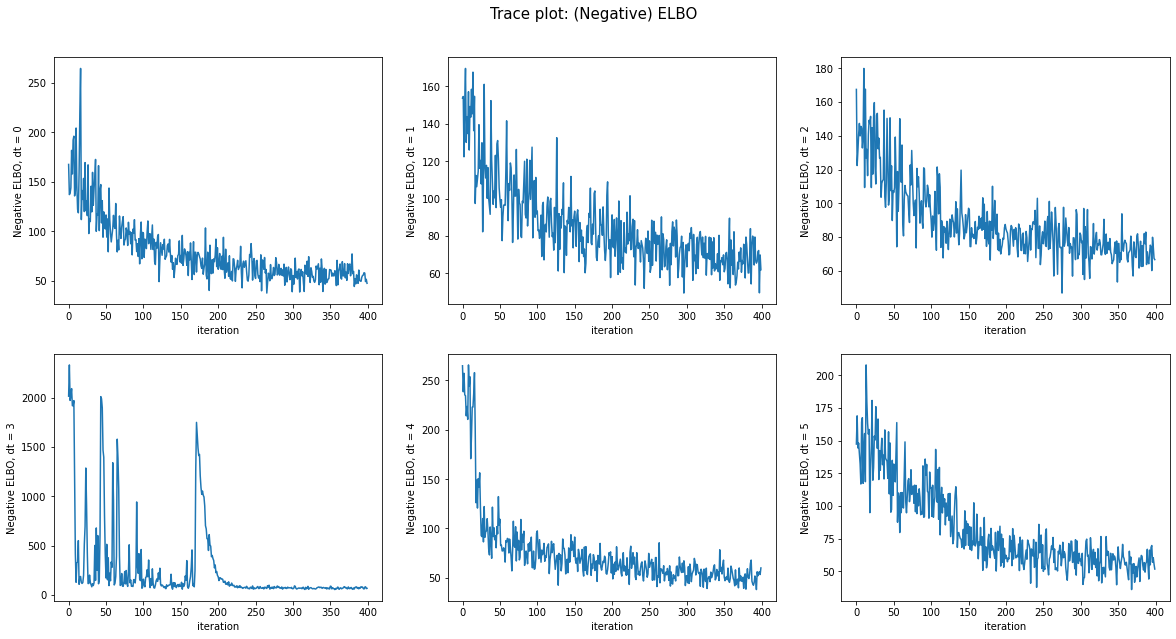

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

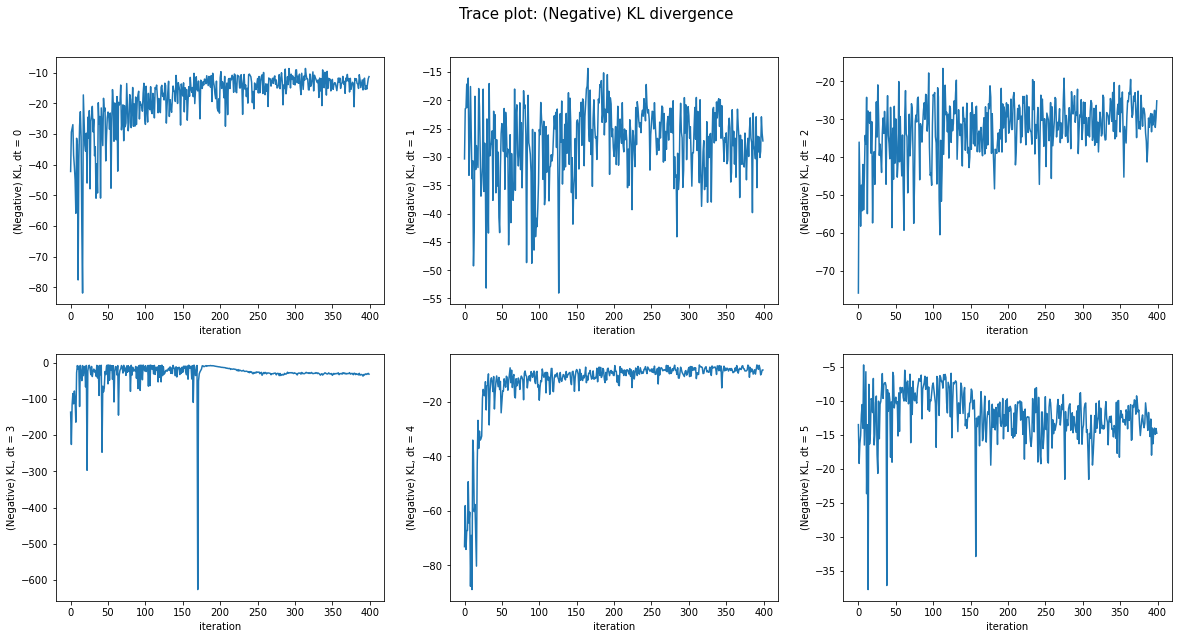

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

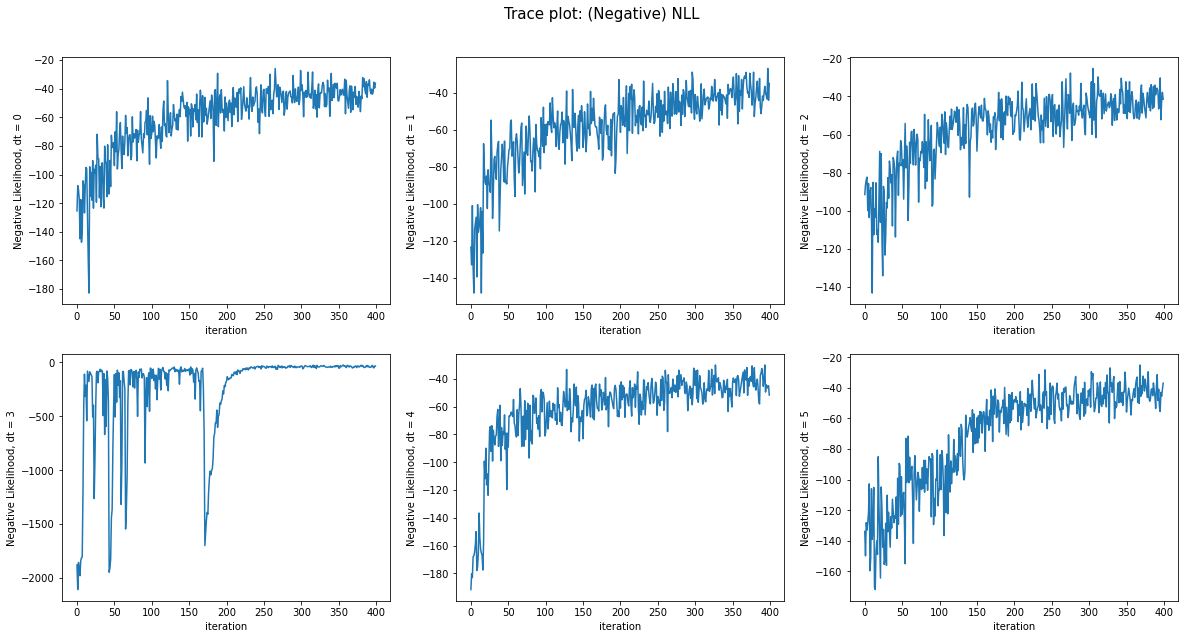

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(NLL_traces[t, :])), NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) NLL", size=15, y=0.95)
plt.show()

Trace plot: parameters

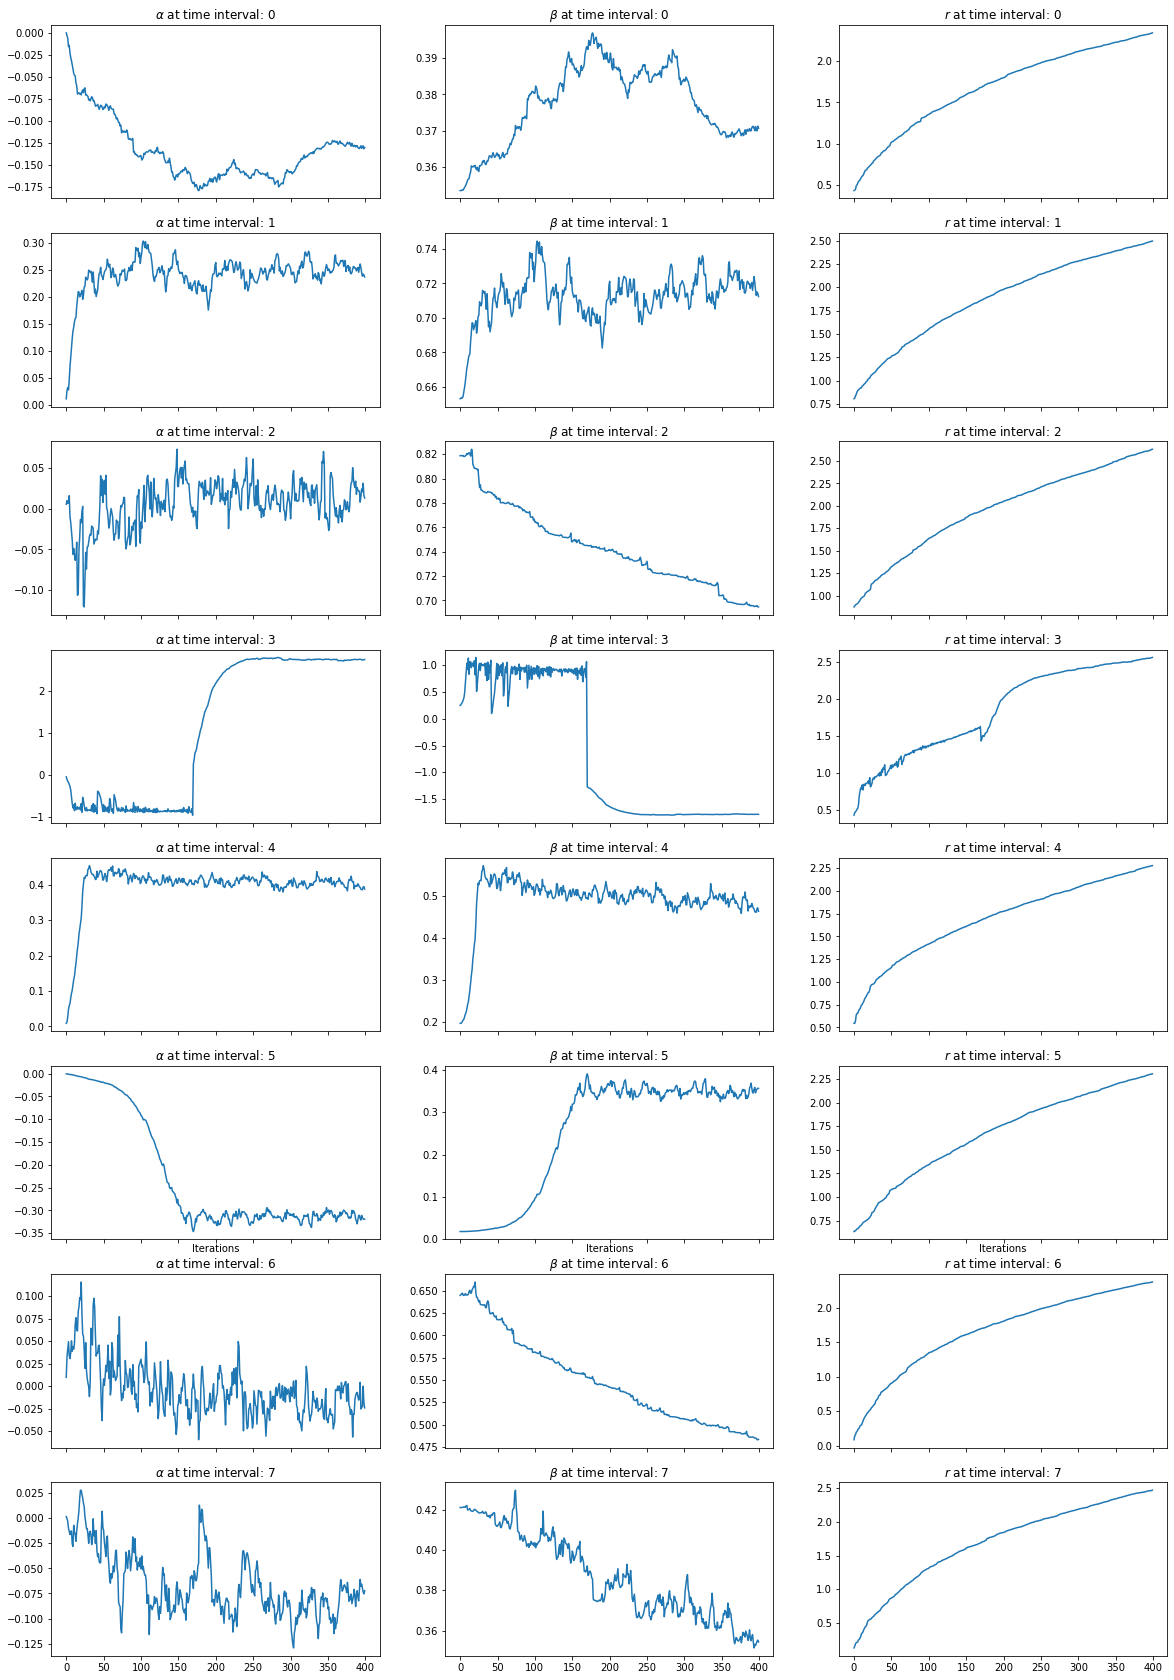

In [36]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$\beta$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

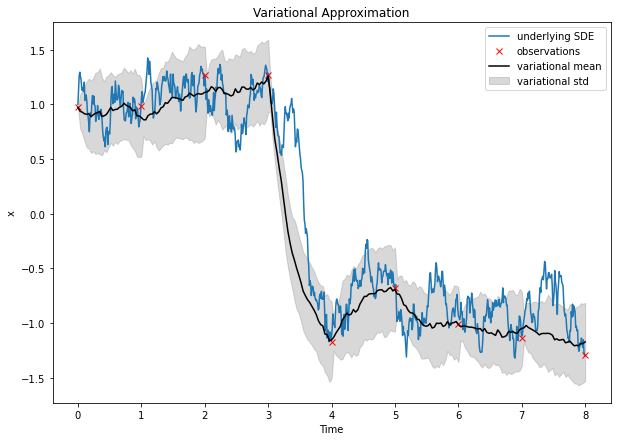

In [37]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE")
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()